In [2]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)

# Building Neural network in tensorflow

In this part of the assignment you will build a neural network using tensorflow. Remember that there are two parts to implement a tensorflow model:

- Create the computation graph
- Run the graph

## 1.0 - Problem statement: SIGNS Dataset

The goal is to build an algorithm that would facilitate communications from a speech-impaired person to someone who doesn't understand sign language.

- **Training set**: 1080 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (180 pictures per number).
- **Test set**: 120 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (20 pictures per number).

Note that this is a subset of the SIGNS dataset. The complete dataset contains many more signs.

Here are examples for each number, and how an explanation of how we represent the labels. These are the original pictures, before we lowered the image resolutoion to 64 by 64 pixels.
<img src="images/hands.png" style="width:800px;height:350px;"><caption><center> <u><font color='purple'> **Figure 1**</u><font color='purple'>: SIGNS dataset <br> <font color='black'> </center>


Run the following code to load the dataset.

In [3]:
# Loading the dataset 
# this might take a minute or so
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

Change the index below and run the cell to visualize some examples in the dataset.

y = 5


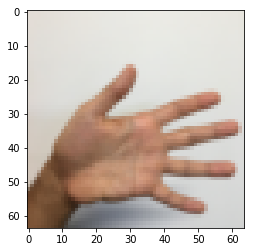

In [5]:
# Example of a picture
index = 0
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

### 1.1 - Flatten and normalize dataset
As usual you should flatten the image dataset, then normalize it by dividing by 255. On top of that, you will convert each label to a one-hot vector as shown in Figure 1. We should use the `convert_to_one_hot` developed in class (imported here). Run the cell below to do so.

In [6]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0],-1).T
# Normalize image vectors
X_train = X_train_flatten / 255.
X_test = X_test_flatten / 255
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


**Expected Output**: 

<table> 
    <tr> 
        <td>
            **number of training examples**
        </td>
        <td>
        1080
        </td>
    </tr>
    <tr> 
        <td>
            **number of test examples**
        </td>
        <td>
        120
        </td>
    </tr>
     <tr> 
        <td>
            **X_train shape**
        </td>
        <td>
        (12288, 1080)
        </td>
    </tr>
     <tr> 
        <td>
            **Y_train shape**
        </td>
        <td>
        (6, 1080)
        </td>
    </tr>
      <tr> 
        <td>
            **X_test shape**
        </td>
        <td>
        (12288, 120)
        </td>
    </tr>
      <tr> 
        <td>
            **Y_test shape**
        </td>
        <td>
        (6, 120)
        </td>
    </tr>

</table>

**Note** that 12288 comes from $64 \times 64 \times 3$. Each image is square, 64 by 64 pixels, and 3 is for the RGB colors. Please make sure all these shapes make sense to you before continuing.

**Your goal** is to build an algorithm capable of recognizing a sign with high accuracy. To do so, you are going to build a tensorflow model that is almost the same as one you have previously built in numpy for cat recognition (but now using a softmax output). It is a great occasion to compare your numpy implementation to the tensorflow one. 

**The model** is *LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX*. The SIGMOID output layer has been converted to a SOFTMAX. A SOFTMAX layer generalizes SIGMOID to when there are more than two classes. 

### 1.2 - Create placeholders

Your first task is to create placeholders for `X` and `Y`. This will allow you to later pass your training data in when you run your session. 

**Exercise:** Implement the function below to create the placeholders in tensorflow.

In [7]:
# GRADED FUNCTION: create_placeholders

def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    
    X = tf.placeholder(tf.float32, [n_x, None])
    Y = tf.placeholder(tf.float32, [n_y, None])
    
    
    return X, Y

In [8]:
X, Y = create_placeholders(12288, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(12288, ?), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(6, ?), dtype=float32)


**Expected Output**: 

<table> 
    <tr> 
        <td>
            **X**
        </td>
        <td>
        Tensor("Placeholder_1:0", shape=(12288, ?), dtype=float32) (not necessarily Placeholder_1)
        </td>
    </tr>
    <tr> 
        <td>
            **Y**
        </td>
        <td>
        Tensor("Placeholder_2:0", shape=(10, ?), dtype=float32) (not necessarily Placeholder_2)
        </td>
    </tr>

</table>

### 1.3 - Initializing the parameters

Your second task is to initialize the parameters in tensorflow.

**Exercise:** Implement the function below to initialize the parameters in tensorflow. You are going use Xavier Initialization for weights and Zero Initialization for biases. The shapes are given below. As an example, to help you, for W1 and b1 you could use: 

```python
W1 = tf.get_variable("W1", [25,12288], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
```
Please use `seed = 1` to make sure your results match ours.

In [11]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match mine!
        
    
    W1 = tf.get_variable("W1", [25, 12288], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 25], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [6, 12], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [6,1], initializer = tf.zeros_initializer())
    

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [12]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters()
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))

W1 = <tf.Variable 'W1:0' shape=(25, 12288) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>


**Expected Output**: 

<table> 
    <tr> 
        <td>
            **W1**
        </td>
        <td>
         < tf.Variable 'W1:0' shape=(25, 12288) dtype=float32_ref >
        </td>
    </tr>
    <tr> 
        <td>
            **b1**
        </td>
        <td>
        < tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref >
        </td>
    </tr>
    <tr> 
        <td>
            **W2**
        </td>
        <td>
        < tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref >
        </td>
    </tr>
    <tr> 
        <td>
            **b2**
        </td>
        <td>
        < tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref >
        </td>
    </tr>

</table>

As expected, the parameters haven't been evaluated yet.

## 2 - Forward propagation in tensorflow 

You will now implement the forward propagation module in tensorflow. The function will take in a dictionary of parameters and it will complete the forward pass. The functions you will be using are: 

- `tf.add(...,...)` to do an addition
- `tf.matmul(...,...)` to do a matrix multiplication
- `tf.nn.relu(...)` to apply the ReLU activation

**Question:** Implement the forward pass of the neural network. We commented for you the numpy equivalents so that you can compare the tensorflow implementation to numpy. It is important to note that the forward propagation stops at `z3`. The reason is that in tensorflow the last linear layer output is given as input to the function computing the loss. Therefore, you don't need `a3`!



In [15]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # Use Tensorflow:                                      # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                                         # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                              # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                                              # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                              # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                                              # Z3 = np.dot(W3,Z2) + b3
    
    
    return Z3

In [16]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(12288, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    print("Z3 = " + str(Z3))

Z3 = Tensor("Add_2:0", shape=(6, ?), dtype=float32)


**Expected Output**: 

<table> 
    <tr> 
        <td>
            **Z3**
        </td>
        <td>
        Tensor("Add_2:0", shape=(6, ?), dtype=float32)
        </td>
    </tr>

</table>

You may have noticed that the forward propagation doesn't output any cache. You will understand why below, when we get to brackpropagation.

## 3 - Compute cost

As seen before, it is very easy to compute the cost using:
```python
tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ..., labels = ...))
```
**Question**: Implement the cost function below. 
- It is important to know that the "`logits`" and "`labels`" inputs of `tf.nn.softmax_cross_entropy_with_logits` are expected to be of shape (number of examples, num_classes). We have thus transposed Z3 and Y for you.
- Besides, `tf.reduce_mean` basically does the summation over the examples.

In [19]:
# GRADED FUNCTION: compute_cost 

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    # we need to change the shape such that each row represent one data point (instead of a column)
    # use Tensorflow
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                                 labels=labels))
   
    
    return cost

In [20]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(12288, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    print("cost = " + str(cost))

cost = Tensor("Mean:0", shape=(), dtype=float32)


**Expected Output**: 

<table> 
    <tr> 
        <td>
            **cost**
        </td>
        <td>
        Tensor("Mean:0", shape=(), dtype=float32)
        </td>
    </tr>

</table>

## 4 - Backward propagation & parameter updates

This is where you become grateful to programming frameworks. All the backpropagation and the parameters update is taken care of in 1 line of code. It is very easy to incorporate this line in the model.

After you compute the cost function. You will create an "`optimizer`" object. You have to call this object along with the cost when running the tf.session. When called, it will perform an optimization on the given cost with the chosen method and learning rate.

For instance, for gradient descent the optimizer would be:
```python
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
```

To make the optimization you would do:
```python
_ , c = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
```

This computes the backpropagation by passing through the tensorflow graph in the reverse order. From cost to inputs.

**Note** When coding, we often use `_` as a "throwaway" variable to store values that we won't need to use later. Here, `_` takes on the evaluated value of `optimizer`, which we don't need (and `c` takes the value of the `cost` variable). 

## 5 - Building the model

Now, you will bring it all together! 

**Exercise:** Implement the model. You will be calling the functions you had previously implemented.

In [26]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)
    

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
        
    # Initialize all global variables in tensorflow graph 
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                # populate feed_dict
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y:minibatch_Y})
                
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Run the following cell to train your model! On my machine it takes about 8 minutes. Your "Cost after epoch 100" should be 1.016458. If it's not, don't waste time; interrupt the training by clicking on the square (⬛) in the upper bar of the notebook, and try to correct your code. If it is the correct cost, take a break and come back in 5 minutes!

Cost after epoch 0: 1.855702
Cost after epoch 100: 1.016411
Cost after epoch 200: 0.733256
Cost after epoch 300: 0.572957
Cost after epoch 400: 0.468875
Cost after epoch 500: 0.381083
Cost after epoch 600: 0.313972
Cost after epoch 700: 0.254411
Cost after epoch 800: 0.203953
Cost after epoch 900: 0.166660
Cost after epoch 1000: 0.142506
Cost after epoch 1100: 0.107757
Cost after epoch 1200: 0.086087
Cost after epoch 1300: 0.060919
Cost after epoch 1400: 0.051012


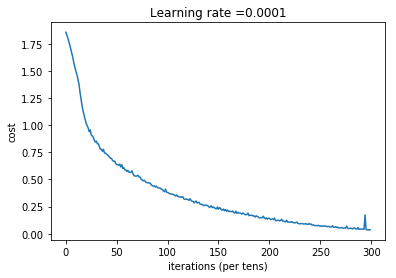

Parameters have been trained!
Train Accuracy: 0.9990741
Test Accuracy: 0.725


In [27]:
parameters = model(X_train, Y_train, X_test, Y_test)

**Expected Output**:

<table> 
     <tr> 
        <td>
            **Cost after epoch 0**
        </td>
        <td>
        1.855702
        </td>
    <tr> 
    <tr> 
        <td>
            **Cost after epoch 100**
        </td>
        <td>
        1.016458
        </td>
    <tr> 
        <td>
            **Train Accuracy**
        </td>
        <td>
        0.999074
        </td>
    </tr>
    <tr> 
        <td>
            **Test Accuracy**
        </td>
        <td>
        0.716667
        </td>
    </tr>

</table>

Amazing, your algorithm can recognize a sign representing a figure between 0 and 5 with 71.7% accuracy.

**Insights**:
- Your model seems big enough to fit the training set well. However, given the difference between train and test accuracy, you could try to add L2 or dropout regularization to reduce overfitting. 
- Think about the session as a block of code to train the model. Each time you run the session on a minibatch, it trains the parameters. In total you have run the session a large number of times (1500 epochs) until you obtained well trained parameters.

## 6 - Test with your own image 

You can now take a picture of your hand and see the output of your model. To do that:
    1. Click on "File" in the upper bar of this notebook, then click "Open".
    2. Add your image to this Jupyter Notebook's directory, in the "images" folder
    3. Write your image's name in the following code
    4. Run the code and check if the algorithm is right!

In [1]:
import scipy
from PIL import Image
from scipy import ndimage

## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "sign.jpg"
## END CODE HERE ##

# We preprocess your image to fit your algorithm.
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64)).reshape((1, 64*64*3)).T
my_image_prediction = predict(my_image, parameters)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))

NameError: name 'np' is not defined

<font color='blue'>
**What you should remember**:
- Tensorflow is a programming framework used in deep learning
- The two main object classes in tensorflow are Tensors and Operators. 
- When you code in tensorflow you have to take the following steps:
    - Create a graph containing Tensors (Variables, Placeholders ...) and Operations (tf.matmul, tf.add, ...)
    - Create a session
    - Initialize the session
    - Run the session to execute the graph
- You can execute the graph multiple times as you've seen in model()
- The backpropagation and optimization is automatically done when running the session on the "optimizer" object.